# SNLI Pretraining
Seeing if doing Sentence-Bert style pretraining will help our performance

In [1]:
import transformer_lens
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import numpy as np

import torch.nn.functional as F

from tqdm import tqdm

import random

In [2]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
# Load datasets
train_set = load_dataset("sentence-transformers/stsb", split="train")
val_set   = load_dataset("sentence-transformers/stsb", split="validation")
test_set  = load_dataset("sentence-transformers/stsb", split="test")

first_train  = torch.load('gpt2_medium_train_acts_1.npy')
second_train = torch.load('gpt2_medium_train_acts_2.npy')

first_test = torch.load('gpt2_medium_test_acts_1.npy')
second_test = torch.load('gpt2_medium_test_acts_2.npy')

train_scores = torch.Tensor(train_set['score'])
test_scores = torch.Tensor(test_set['score'])

premise_acts = torch.load("premise_acts.pt")
hypothesis_acts = torch.load("hypothesis_acts.pt")
labels = torch.Tensor(torch.load("labels.pt")).long()

In [4]:
dataset = list(zip(premise_acts, hypothesis_acts, labels))

In [9]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i < 12:
        return 1
    else:
        return 2

class NLIModel(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256, dropout_rate=0.1):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        d_hidden = d_in//2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_in),
            nn.LayerNorm(d_in),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_in, d_in),
            nn.LayerNorm(d_in),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_in, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
        )
        
        self.classify = nn.Sequential(
            nn.Linear(d_hidden*3, d_hidden*3),
            nn.GELU(),
            nn.Linear(d_hidden*3, 3)
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x, y):
        x_embed = self.encode(x)
        y_embed = self.encode(y)

        total = torch.cat([x_embed, y_embed, x_embed - y_embed], dim=-1)
        return self.classify(total)

def train_epoch(models, premises, hypotheses, labels, optimizers, batch_size=64):
    indices = torch.randperm(premises.shape[0])

    shuffled_premises = premises[indices]
    shuffled_hypotheses = hypotheses[indices]
    shuffled_labels = labels[indices]
    
    losses = []
    n_batches = shuffled_premises.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            premise_batch = shuffled_premises[start_idx:end_idx, i].cuda()
            hypothesis_batch = shuffled_hypotheses[start_idx:end_idx, i].cuda()
            label_batch = shuffled_labels[start_idx:end_idx].cuda()
            
            optimizer.zero_grad()
            
            # Forward pass
            logits = model(premise_batch, hypothesis_batch)
            loss = F.cross_entropy(logits, label_batch)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Setup models and optimizers
n_layers = 24
nli_models = [NLIModel(i).cuda() for i in range(n_layers)]

# Learning rates increase linearly from 3e-4 to 9e-4
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]
optimizers = [torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01) 
              for model, lr in zip(nli_models, lrs)]

# Training loop
n_epochs = 50
best_losses = float('inf') * np.ones(n_layers)
patience = 10
patience_counter = 0

for epoch in tqdm(range(n_epochs)):
    # Train
    train_losses = train_epoch(nli_models, premise_acts, hypothesis_acts, labels, 
                             optimizers, batch_size=64)
    
    # Early stopping check
    if np.mean(train_losses) < np.mean(best_losses):
        best_losses = train_losses
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Average Loss: {np.mean(train_losses):.4f}")

  2%|█▍                                                                       | 1/50 [00:12<10:35, 12.97s/it]

Epoch 0, Average Loss: 1.0493


 22%|███████████████▊                                                        | 11/50 [02:17<08:05, 12.45s/it]

Epoch 10, Average Loss: 0.6458


 42%|██████████████████████████████▏                                         | 21/50 [04:21<05:58, 12.37s/it]

Epoch 20, Average Loss: 0.4103


 62%|████████████████████████████████████████████▋                           | 31/50 [06:25<03:57, 12.48s/it]

Epoch 30, Average Loss: 0.2879


 82%|███████████████████████████████████████████████████████████             | 41/50 [08:30<01:52, 12.47s/it]

Epoch 40, Average Loss: 0.2214


100%|████████████████████████████████████████████████████████████████████████| 50/50 [10:21<00:00, 12.43s/it]


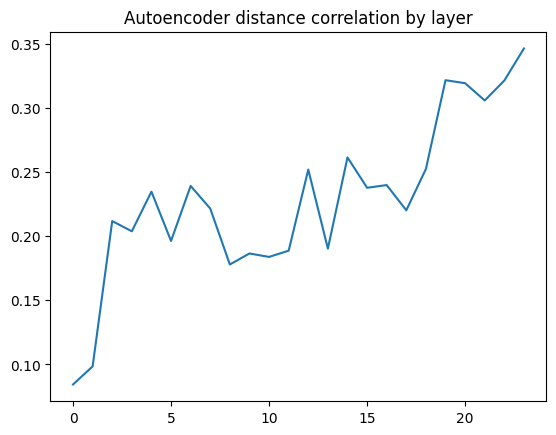

In [10]:
from copy import deepcopy
from torch.nn.functional import cosine_similarity

encoders = [deepcopy(ae.encode).cuda() for ae in nli_models]
[m.eval() for m in encoders]

# Do a forward pass on each encoder for each pair of training sentences and collect the cosine distances
batch_size = 32
n_batches = first_test.shape[0] // batch_size

corrs = []
for l in range(n_layers):
    distances = []
    for i in range(n_batches+1):
        f = first_test[i*batch_size: (i+1)*batch_size, l,:]
        s = second_test[i*batch_size: (i+1)*batch_size, l, :]
    
        f_embed = encoders[l](f.cuda())
        s_embed = encoders[l](s.cuda())
    
        sims = cosine_similarity(f_embed, s_embed, dim=-1)
    
        distances.append(sims)

    corr = torch.corrcoef(torch.stack([torch.cat(distances).cpu(), test_scores]))[1][0]
    corrs.append(corr.item())

plt.title("Autoencoder distance correlation by layer")
plt.plot(corrs)

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self, mlp):
        super().__init__()
        self.mlp = mlp

    def forward(self, x1, x2):
        h1 = self.mlp(x1)
        h2 = self.mlp(x2)
        return F.cosine_similarity(h1, h2, dim=-1)

class LayerwiseSiameseNetworks(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256):
        super().__init__()
        self.n_layers = n_layers
        self.layer_nets = nn.ModuleList([SiameseNetwork(encoders[i]) for i in range(n_layers)])

    def forward(self, x1, x2):
        similarities = []
        for layer in range(self.n_layers):
            net_at_layer = self.layer_nets[layer].cuda()
            # Get the activations at the given layer
            x1_l = x1[:, layer].cuda()
            x2_l = x2[:, layer].cuda()

            sim_at_layer = net_at_layer(x1_l, x2_l)
            # print(sim_at_layer.shape)
            similarities.append(sim_at_layer)

        return torch.stack(similarities, dim=-1)

class SimilarityLearner(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256, d_out_hidden=512, dropout=0.1):
        super().__init__()
        self.layer_nets = LayerwiseSiameseNetworks(encoders, n_layers, d_in, d_hidden)

        self.mlp = nn.Sequential(
            nn.Linear(n_layers, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, 1),
            nn.Hardsigmoid()
        )

    def forward(self, x1, x2, training=True):
        layerwise_similarities = self.layer_nets(x1, x2)
        similarity = self.mlp(layerwise_similarities)
        return similarity.squeeze()

In [12]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

from copy import deepcopy
cloned_encoders = [deepcopy(e).encode for e in nli_models]

similarity_learner = SimilarityLearner(cloned_encoders, d_hidden=512).to('cuda:0')
# similarity_learner = SimilarityLearner([Autoencoder(i) for i in range(24)], d_hidden=512).to('cuda:0')
optimizer = torch.optim.Adam(similarity_learner.parameters(), lr=3e-4)

def train_epoch(model, first_acts, second_acts, scores, optimizer, batch_size=128):
    indices = torch.randperm(first_acts.shape[0])
    shuffled_first = first_acts[indices]
    shuffled_second = second_acts[indices]
    shuffled_scores = scores[indices]

    model.train()
    total_loss = 0
    n_batches = first_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        x1_batch = shuffled_first[start_idx:end_idx].cuda()
        x2_batch = shuffled_second[start_idx:end_idx].cuda()
        scores_batch = shuffled_scores[start_idx:end_idx].cuda()
        
        optimizer.zero_grad()
        
        sims = model(x1_batch, x2_batch)

        resids = sims - scores_batch
        loss = torch.log((sims - scores_batch).var())
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / n_batches

best_test_corr = 0
best_model = None

for epoch in tqdm(range(150)):
    # Training
    # loss = train_epoch(similarity_learner, first_train_fake, second_train_fake, train_scores_fake, optimizer)
    loss = train_epoch(similarity_learner, first_train, second_train, train_scores, optimizer)
    
    # Evaluation
    similarity_learner.eval()
    with torch.no_grad():
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get training correlations
            train_preds = similarity_learner(first_train.cuda(), second_train.cuda(), training=False)
            train_corr = torch.corrcoef(torch.stack([train_preds.cpu(), train_scores]))[0,1]
            
            # Get test correlations
            test_preds = similarity_learner(first_test.cuda(), second_test.cuda(), training=False)
            test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]

            if test_corr > best_test_corr:
                best_test_corr = test_corr
                best_model = deepcopy(similarity_learner)

            print(f"Epoch {epoch+1}")
            print(f"Loss: {loss:.10f}")
            print(f"Train correlation: {train_corr*100:.3f}")
            print(f"Test correlation: {test_corr*100:.3f}\n")

  7%|████▋                                                                  | 10/150 [00:27<06:42,  2.88s/it]

Epoch 10
Loss: -4.5385008183
Train correlation: 94.613
Test correlation: 61.291



 13%|█████████▍                                                             | 20/150 [00:54<06:12,  2.87s/it]

Epoch 20
Loss: -5.3568434282
Train correlation: 97.937
Test correlation: 65.836



 20%|██████████████▏                                                        | 30/150 [01:23<05:57,  2.98s/it]

Epoch 30
Loss: -5.7708309130
Train correlation: 98.583
Test correlation: 65.855



 27%|██████████████████▉                                                    | 40/150 [01:51<05:18,  2.89s/it]

Epoch 40
Loss: -6.1085568775
Train correlation: 99.092
Test correlation: 65.988



 33%|███████████████████████▋                                               | 50/150 [02:20<04:55,  2.95s/it]

Epoch 50
Loss: -6.2854198759
Train correlation: 99.301
Test correlation: 66.009



 40%|████████████████████████████▍                                          | 60/150 [02:48<04:23,  2.93s/it]

Epoch 60
Loss: -6.6220980883
Train correlation: 99.342
Test correlation: 66.688



 47%|█████████████████████████████████▏                                     | 70/150 [03:16<03:53,  2.91s/it]

Epoch 70
Loss: -6.6681992791
Train correlation: 99.389
Test correlation: 66.811



 53%|█████████████████████████████████████▊                                 | 80/150 [03:44<03:25,  2.94s/it]

Epoch 80
Loss: -6.9753270149
Train correlation: 99.450
Test correlation: 68.007



 60%|██████████████████████████████████████████▌                            | 90/150 [04:12<02:52,  2.88s/it]

Epoch 90
Loss: -6.9509721453
Train correlation: 99.550
Test correlation: 66.721



 67%|██████████████████████████████████████████████▋                       | 100/150 [04:41<02:27,  2.95s/it]

Epoch 100
Loss: -7.1094319495
Train correlation: 99.560
Test correlation: 67.156



 73%|███████████████████████████████████████████████████▎                  | 110/150 [05:09<01:57,  2.95s/it]

Epoch 110
Loss: -7.2924631726
Train correlation: 99.687
Test correlation: 67.121



 80%|████████████████████████████████████████████████████████              | 120/150 [05:38<01:29,  2.97s/it]

Epoch 120
Loss: -7.1875042807
Train correlation: 99.275
Test correlation: 65.696



 87%|████████████████████████████████████████████████████████████▋         | 130/150 [06:07<00:59,  2.98s/it]

Epoch 130
Loss: -7.4206045216
Train correlation: 99.737
Test correlation: 66.514



 93%|█████████████████████████████████████████████████████████████████▎    | 140/150 [06:36<00:29,  2.98s/it]

Epoch 140
Loss: -7.5391922214
Train correlation: 99.791
Test correlation: 66.363



100%|██████████████████████████████████████████████████████████████████████| 150/150 [07:05<00:00,  2.84s/it]

Epoch 150
Loss: -7.5373052142
Train correlation: 99.712
Test correlation: 66.216



In [13]:
param_count = sum([w.numel() for w in similarity_learner.parameters()])
f"This model has {param_count} parameters!"

'This model has 63640577 parameters!'

In [14]:
# test_preds = best_model(first_test.cuda(), second_test.cuda(), training=False)
# test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]
# print(test_corr)

# from scipy.stats import spearmanr
# print(spearmanr(test_preds.detach().cpu(), test_scores))

## Residual histogram and qq plot

In [ ]:
# residuals = (test_preds.cpu().detach().numpy() - test_scores.numpy())
# residuals.mean(), residuals.std()

In [ ]:
# import matplotlib.pyplot as plt
# import scipy.stats as stats

# def plot_qq(residuals):
#    fig = plt.figure(figsize=(10, 4))
   
#    # Left plot: Histogram of residuals
#    plt.subplot(121)
#    plt.hist(residuals, bins=30, density=True, range=[-1,1])
#    plt.title('Distribution of Residuals')
   
#    # Right plot: Q-Q plot
#    plt.subplot(122)
#    stats.probplot(residuals, dist="norm", plot=plt)
#    plt.title('Q-Q Plot')
   
#    plt.tight_layout()
#    plt.show()

# # Usage:
# plot_qq(residuals)
# print(stats.shapiro(residuals))

The Shapiro-Wilk test results (p < 0.05) lead us to reject the null hypothesis of normality, indicating evidence of departure from a normal distribution

In [ ]:
# worst_overdone = np.absolute(residuals).argsort()[-25:]

In [ ]:
# list(zip(test_set.select(worst_overdone)['sentence1'], test_set.select(worst_overdone)['sentence2'], test_scores[worst_overdone], test_preds[worst_overdone]))

In [ ]:
# Load in sentence similarity benchmark. Form is (sentence1, sentence2, similarity score)
ds = load_dataset("mteb/stsbenchmark-sts")
ds_test = ds['test']
ds_train = ds['train']

# Unique sentences in test set
test_unique = set(ds_test['sentence1'] + ds_test['sentence2'])

# Unique sentences in train set
train_unique = set(ds_train['sentence1'] + ds_train['sentence2'])

# % of train set containing sentences common to train and test
len(test_unique & train_unique) / len(ds_test)